# Yelp, performance

Applying collaborative classification on the states. (Easy problem)

In [1]:
import collabclass
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
classes = (
    "AZ",
    "NV",
    "ON",
    "OH",
    "NC",
    "PA",
    "QC",
    "AB",
    "WI",
    "IL",
)

cls2idx = {cls: idx for idx, cls in enumerate(classes)}
k = len(cls2idx)

The dataset is publicly available at <https://www.yelp.com/dataset>.

In [3]:
%%time
label = dict()
with open("../_data/yelp/yelp_academic_dataset_business.json") as f:
    for line in f:
        biz = json.loads(line)
        if biz["state"] in classes:
            label[biz["business_id"]] = biz["state"]

CPU times: user 1.94 s, sys: 64.6 ms, total: 2.01 s
Wall time: 2.01 s


In [4]:
%%time

user_cnt = 0
item_cnt = 0
user2idx = dict()
item2idx = dict()

edges = list()

with open("../_data/yelp/yelp_academic_dataset_review.json") as f:
    for line in f:
        x = json.loads(line)
        uid = x["user_id"]
        bid = x["business_id"]
        if bid not in label:
            # We don't have the business -> skip.
            continue
        if bid not in item2idx:
            item2idx[bid] = item_cnt
            item_cnt += 1
        if uid not in user2idx:
            user2idx[uid] = user_cnt
            user_cnt += 1
        edges.append((user2idx[uid], item2idx[bid]))

m = user_cnt
n = item_cnt
    
graph = collabclass.graph_from_edges(m, n, edges)

CPU times: user 1min 14s, sys: 3.37 s, total: 1min 17s
Wall time: 1min 18s


In [5]:
print("Number of users: {:,}".format(m))
print("Number of items:   {:,}".format(n))
print("Number of edges: {:,}".format(len(graph.user_edges)))

Number of users: 1,962,440
Number of items:   207,974
Number of edges: 7,990,277


In [6]:
idx2item = {v: k for k, v in item2idx.items()}
vs = list()
for j in range(n):
    cat = label[idx2item[j]]
    vs.append(cls2idx[cat])
vs = np.array(vs)

In [7]:
np.random.seed(0)
vs_hat = collabclass.symmetric_channel(vs, k, delta=0.1)

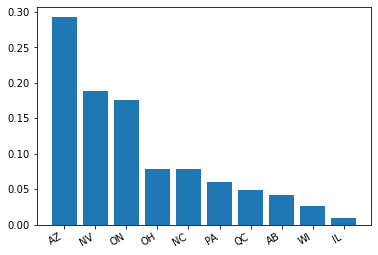

In [8]:
vals, cnts = np.unique(vs, return_counts=True)

fig, ax = plt.subplots()
ax.bar(vals, cnts / cnts.sum());
ax.set_xticks(vals)
ax.set_xticklabels(classes, rotation=30, ha="right");

### CAVI

In [9]:
alpha = np.ones((m, k))
beta = collabclass.init_beta(k, vs_hat, delta=0.75)

In [10]:
%%time
apost, bpost = collabclass.cavi(graph, alpha, beta, 3)
vs_bar = np.argmax(bpost, axis=1)

CPU times: user 9.15 s, sys: 223 ms, total: 9.37 s
Wall time: 9.42 s


In [11]:
collabclass.print_accuracy(vs_bar, vs, vs_hat)

accuracy:   0.9948
error rate: 0.0052
FP rate:    0.0019
FN rate:    0.0342


In [12]:
collabclass.degree_breakdown(vs_bar, vs, graph, qs=(50, 90, 98))

accuracy at 50th percentile (d ≥ 10): 0.9985
accuracy at 90th percentile (d ≥ 81): 0.9993
accuracy at 98th percentile (d ≥ 301): 0.9993


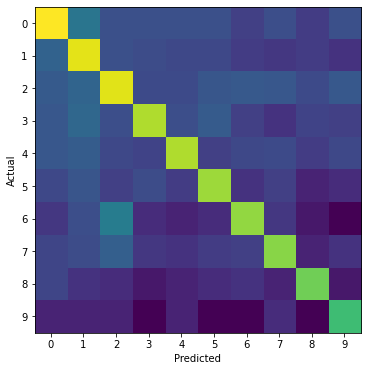

In [13]:
collabclass.confusion_matrix(vs_bar, vs);

In [14]:
collabclass.degree_breakdown_topk(bpost, vs, graph, k=2)

top-2 accuracy at 0th percentile (d ≥ 3): 0.9984
top-2 accuracy at 50th percentile (d ≥ 10): 0.9997
top-2 accuracy at 90th percentile (d ≥ 81): 0.9997
top-2 accuracy at 95th percentile (d ≥ 151): 0.9997


## wvRN

In [15]:
%%time
vs_bar = collabclass.wvrn(graph, vs_hat)

CPU times: user 1.4 s, sys: 52.3 ms, total: 1.45 s
Wall time: 1.45 s


In [16]:
collabclass.print_accuracy(vs_bar, vs, vs_hat)

accuracy:   0.9737
error rate: 0.0263
FP rate:    0.0261
FN rate:    0.0277


In [17]:
collabclass.degree_breakdown(vs_bar, vs, graph, qs=(50, 90, 95, 99))

accuracy at 50th percentile (d ≥ 10): 0.9884
accuracy at 90th percentile (d ≥ 81): 0.9950
accuracy at 95th percentile (d ≥ 151): 0.9960
accuracy at 99th percentile (d ≥ 468): 0.9952


/Users/lucasm/Documents/in-progress/collabclass/lib/collabclass/eval.py:59: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(mat))


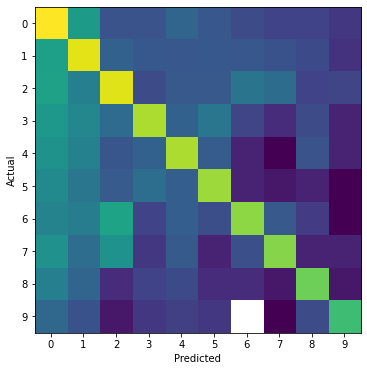

In [18]:
collabclass.confusion_matrix(vs_bar, vs);

## Deep dive into CAVI errors

In [19]:
idx2cls = {v: k for k, v in cls2idx.items()}
vs_bar = np.argmax(bpost, axis=1)
indices = np.argwhere(vs_bar != vs).ravel()
len(indices)

1077

In [20]:
n_revs = [graph.item_idx[i,1] for i in indices]

for cnt, i in sorted(zip(n_revs, indices), reverse=True)[:10]:
    print("---")
    print(f"predicted: {idx2cls[vs[i]]}, actual: {idx2cls[vs_bar[i]]}")
    print(f"{cnt} reviews")
    print(f"https://www.yelp.co.uk/biz/{idx2item[i]}")

---
predicted: NC, actual: AB
605 reviews
https://www.yelp.co.uk/biz/ADV5PA_XMBgbfn92ptu1sA
---
predicted: OH, actual: QC
449 reviews
https://www.yelp.co.uk/biz/xJq2h6RzINWfzb3E0Z3ryQ
---
predicted: NV, actual: WI
328 reviews
https://www.yelp.co.uk/biz/GXXJm8qTZQPARaSpRaED6Q
---
predicted: NV, actual: ON
284 reviews
https://www.yelp.co.uk/biz/WSirMxtVe893j3edfPr_vQ
---
predicted: NC, actual: IL
284 reviews
https://www.yelp.co.uk/biz/cMHgw40ldvUBxTYNeZjHQg
---
predicted: NC, actual: OH
228 reviews
https://www.yelp.co.uk/biz/t0aja59cII8eEVmC_x4sBw
---
predicted: NV, actual: OH
184 reviews
https://www.yelp.co.uk/biz/CuGKpwglLEAxLYxlwp7UUQ
---
predicted: PA, actual: NV
161 reviews
https://www.yelp.co.uk/biz/h23R_mGy3ZdKlOYj57bheQ
---
predicted: AZ, actual: QC
147 reviews
https://www.yelp.co.uk/biz/dS02-F6N5vIsJZPmYmqmBg
---
predicted: AZ, actual: ON
145 reviews
https://www.yelp.co.uk/biz/XKcRPqOo-TCMbeys0LOg6Q
